## Final Evaluation

In this notebook, we will evaluate the best model found which is a RF with the test split

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pipeline import *

import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from datetime import timedelta

from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, \
                  classification_report,  precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
from sklearn.metrics import make_scorer

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
sns.set()
pd.set_option('display.precision', 3)

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42) # for reproducibility
rng = 42

In [2]:
X_train, X_test, y_train, y_test = get_train_test(balanced=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
results = pd.DataFrame(index=[], columns= ['F1 C0', 'F1 C1', 'F1 Macro', 'Recall C0', 'Precision C0', 'AP Macro', 'ROC AUC Macro'])

set()


((55388, 33), (13848, 33), (55388,), (13848,))

In [3]:
def plot_confusion_matrix(y_true, y_pred, vmax = None):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index = ['Not Voted','Voted'],columns = ['Not Voted','Voted'])
    plt.figure(figsize=(5.5,4))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g', vmin=0, vmax=vmax)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

def compute_metrics(y_true,y_pred):
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    recall_0 = recall_score(y_true,y_pred,average='binary',pos_label=0)
    precision_0 = precision_score(y_true,y_pred,average='binary',pos_label=0)
    AP_macro = average_precision_score(y_true,y_pred,average='macro')
    roc_auc_macro = roc_auc_score(y_true,y_pred,average='macro')
    return [f1_score_0,f1_score_1,f1_score_macro,recall_0,precision_0,AP_macro,roc_auc_macro]

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NATIVITY', 'COVIDPAID']),
                                                 ('target_econder',
                                                  TargetEncod...
                                                  ['STATEFIP', 'RELATE', 'RACE',
                                                   'MARST', 'BPL', 'MBPL',
                                                   'FBPL', 'HISPAN', 'EMPSTAT',
                                                   'CLASSWKR',
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=6, min_samples_split=4,
                                        n_estimators=200, random_state=42))])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
RF,0.524,0.851,0.688,0.628,0.45,0.879,0.719


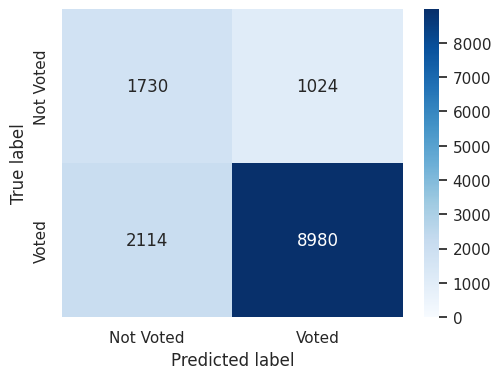

0:01:29.544765
\begin{tabular}{lrrrrrrr}
\toprule
{} &  F1 C0 &  F1 C1 &  F1 Macro &  Recall C0 &  Precision C0 &  AP Macro &  ROC AUC Macro \\
\midrule
RF &  0.524 &  0.851 &     0.688 &      0.628 &         0.450 &     0.879 &          0.719 \\
\bottomrule
\end{tabular}



In [4]:
init_time = time()

# Best parameters found
params = {'class_weight': 'balanced_subsample',
          'max_depth': None,
          'min_samples_leaf': 6,
          'min_samples_split': 4,
          'n_estimators': 200}

# Define and configure the RF pipeline
rf = imbPipeline([
        ('preprocessing', preprocessing_oh_target),
        ('classifier', RandomForestClassifier(**params, random_state=rng))
    ])

# Fit and predict the model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Compute metrics
results.loc['RF'] = compute_metrics(y_test, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_test, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))
#print results to latex
print(results.to_latex(float_format="%.3f"))

<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

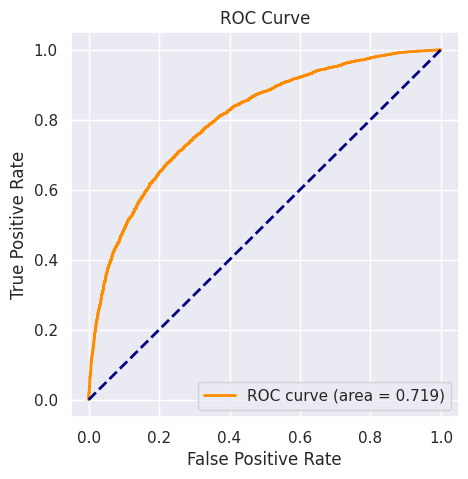

In [5]:
from sklearn.metrics import roc_curve
y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % 0.719)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


<Axes: >

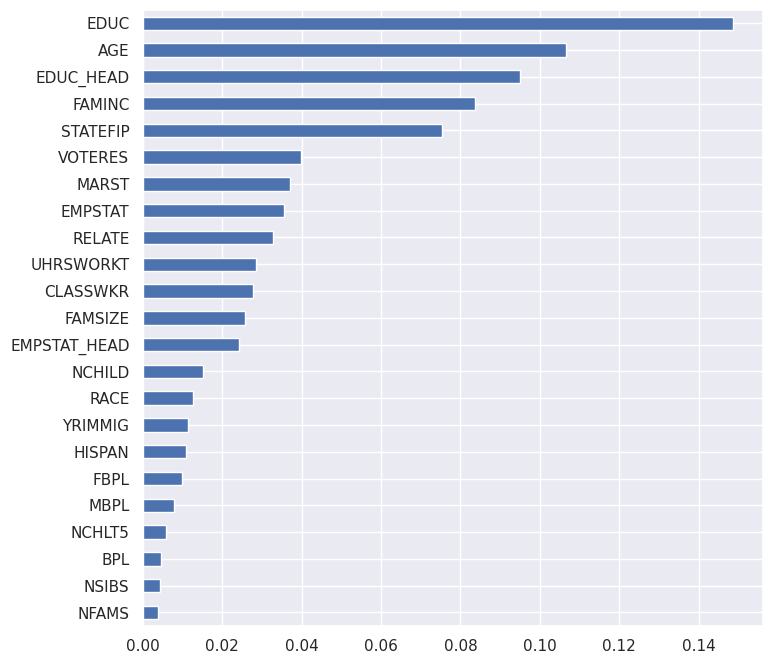

In [6]:
#select names and importance of features of all the variables except the one hot encoded variables
features = num_cols_basic+cat_cols_many+num_cols_imputate+cat_cols_ord
importances = rf[1].feature_importances_[[0,1,2,3,4,5,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]]
var_imp = pd.DataFrame({'importance': importances},
                       index=features)
var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),legend=False)

In [7]:
# sum of importance of all variables without the one-hot encoded variables
sum(var_imp.to_numpy())

array([0.84744576])

### PROVES PERMUTATION_IMPORTANCE

(The following chunk of code takes about 80 min to execute)

In [24]:
from sklearn.inspection import permutation_importance
r_multi = permutation_importance(rf, X_test, y_test, n_repeats=50, random_state=rng, scoring='r2')

{'whiskers': [<matplotlib.lines.Line2D at 0x131e32dd0>,
 'caps': [<matplotlib.lines.Line2D at 0x131dc20d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x131e25590>,
 'medians': [<matplotlib.lines.Line2D at 0x131e33950>,
 'fliers': [<matplotlib.lines.Line2D at 0x1311dadd0>,
 'means': []}

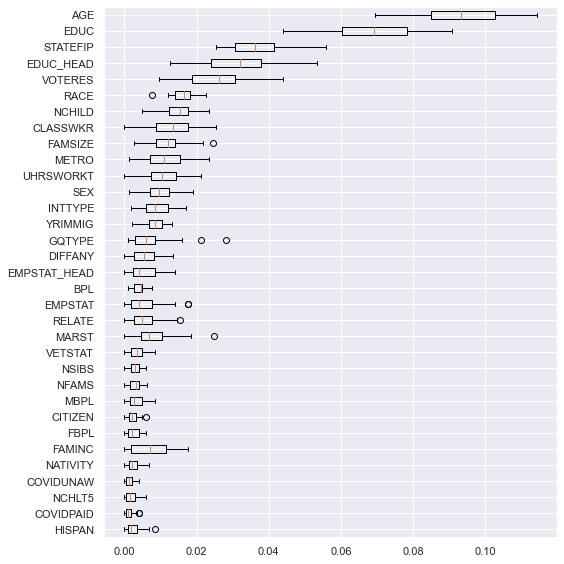

In [29]:
imp=abs(r_multi.importances_mean)
sorted_idx = imp.argsort()
fig, ax = plt.subplots(figsize=(8,8))
ax.boxplot(abs(r_multi.importances[sorted_idx].T),vert=False, labels=X_test.columns[sorted_idx])
fig.tight_layout()
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x13098add0>,
 'caps': [<matplotlib.lines.Line2D at 0x130ed7e90>,
 'boxes': [<matplotlib.lines.Line2D at 0x130eb5590>,
 'medians': [<matplotlib.lines.Line2D at 0x130eed090>,
 'fliers': [<matplotlib.lines.Line2D at 0x130e4d850>,
 'means': []}

Text(0.5, 1.0, 'Permutation Importances (test set)')

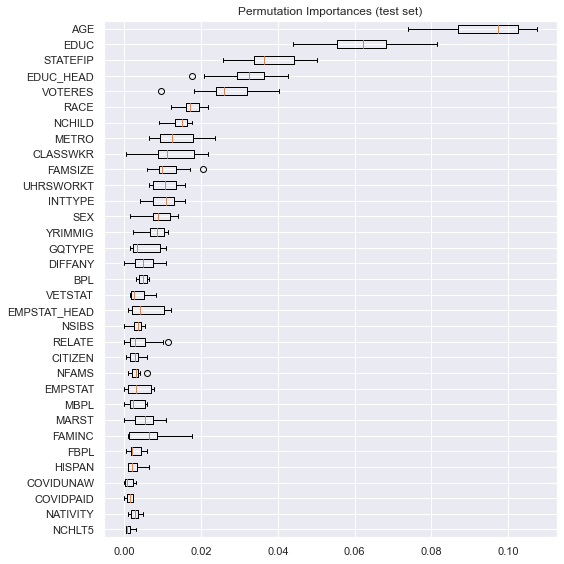

In [23]:
imp=abs(r_multi.importances_mean)
sorted_idx = imp.argsort()
fig, ax = plt.subplots(figsize=(8,8))
ax.boxplot(abs(r_multi.importances[sorted_idx].T),vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()  
plt.show()